In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score


## Question: Does a "Pit" breed matter?

In [4]:
dog_df = pd.read_csv("../main_data/locale_specific_data/Sonoma_nontime_cleaned_ry.csv").drop(["Unnamed: 0"], axis=1)

dog_df['sex_bin'] = 1*(dog_df.sex=="Female")

size_dict = {'PUPPY':0, 'TOY':1, 'SMALL':2, 'MED':3, 'LARGE':4,'X-LRG':5}
dog_df['size_bin'] = dog_df['size'].map(size_dict)
del size_dict

dog_df['breed_pit'] = 1*(dog_df.breed.str.contains("PIT"))

dog_df

,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,intake_season,outcome_season,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit
0,PIT BULL,GRAY/WHITE,Female,MED,2012-09-03,A296009,2013-08-22,2014-04-14,235,TRANSFER,...,2,1,False,none,0.97,1.61,1,1,3,1
1,PIT BULL,BLUE/WHITE,Female,MED,2012-10-09,A294143,2013-08-31,2014-04-14,226,STRAY,...,2,1,False,none,0.89,1.51,1,1,3,1
2,CAROLINA DOG/MIX,GOLD/WHITE,Male,MED,2007-09-07,A281788,2013-09-19,2014-07-30,314,STRAY,...,3,2,False,none,6.03,6.90,0,0,3,0
3,CHIHUAHUA SH,TAN,Male,TOY,2007-10-01,A297574,2013-10-01,2014-01-01,92,OWNER SURRENDER,...,3,0,False,none,6.00,6.25,1,0,1,0
4,PIT BULL,TAN/WHITE,Male,MED,2012-10-29,A298002,2013-10-08,2014-05-22,226,STRAY,...,3,1,True,realtime,0.95,1.57,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6500,LABRADOR RETR/MIX,BR BRINDLE,Female,PUPPY,2023-10-10,A425814,2024-04-18,2024-05-04,16,OWNER SURRENDER,...,1,1,False,none,0.52,0.57,0,1,0,0
6501,LABRADOR RETR/MIX,BL BRINDLE,Female,PUPPY,2023-10-10,A425816,2024-04-18,2024-05-04,16,OWNER SURRENDER,...,1,1,False,none,0.52,0.57,0,1,0,0
6502,LABRADOR RETR/MIX,BLACK,Male,SMALL,2024-01-20,A426010,2024-04-20,2024-04-20,0,STRAY,...,1,1,False,none,0.25,0.25,0,0,2,0
6503,SCHNAUZER MIN/MIX,WHITE,Male,MED,2020-12-16,A426021,2024-04-22,2024-05-08,16,STRAY,...,1,1,False,none,3.35,3.40,0,0,3,0


In [6]:
feature_list = ['sex_bin','size_bin','breed_pit','days_in_shelter','outcome_season','intake_age']


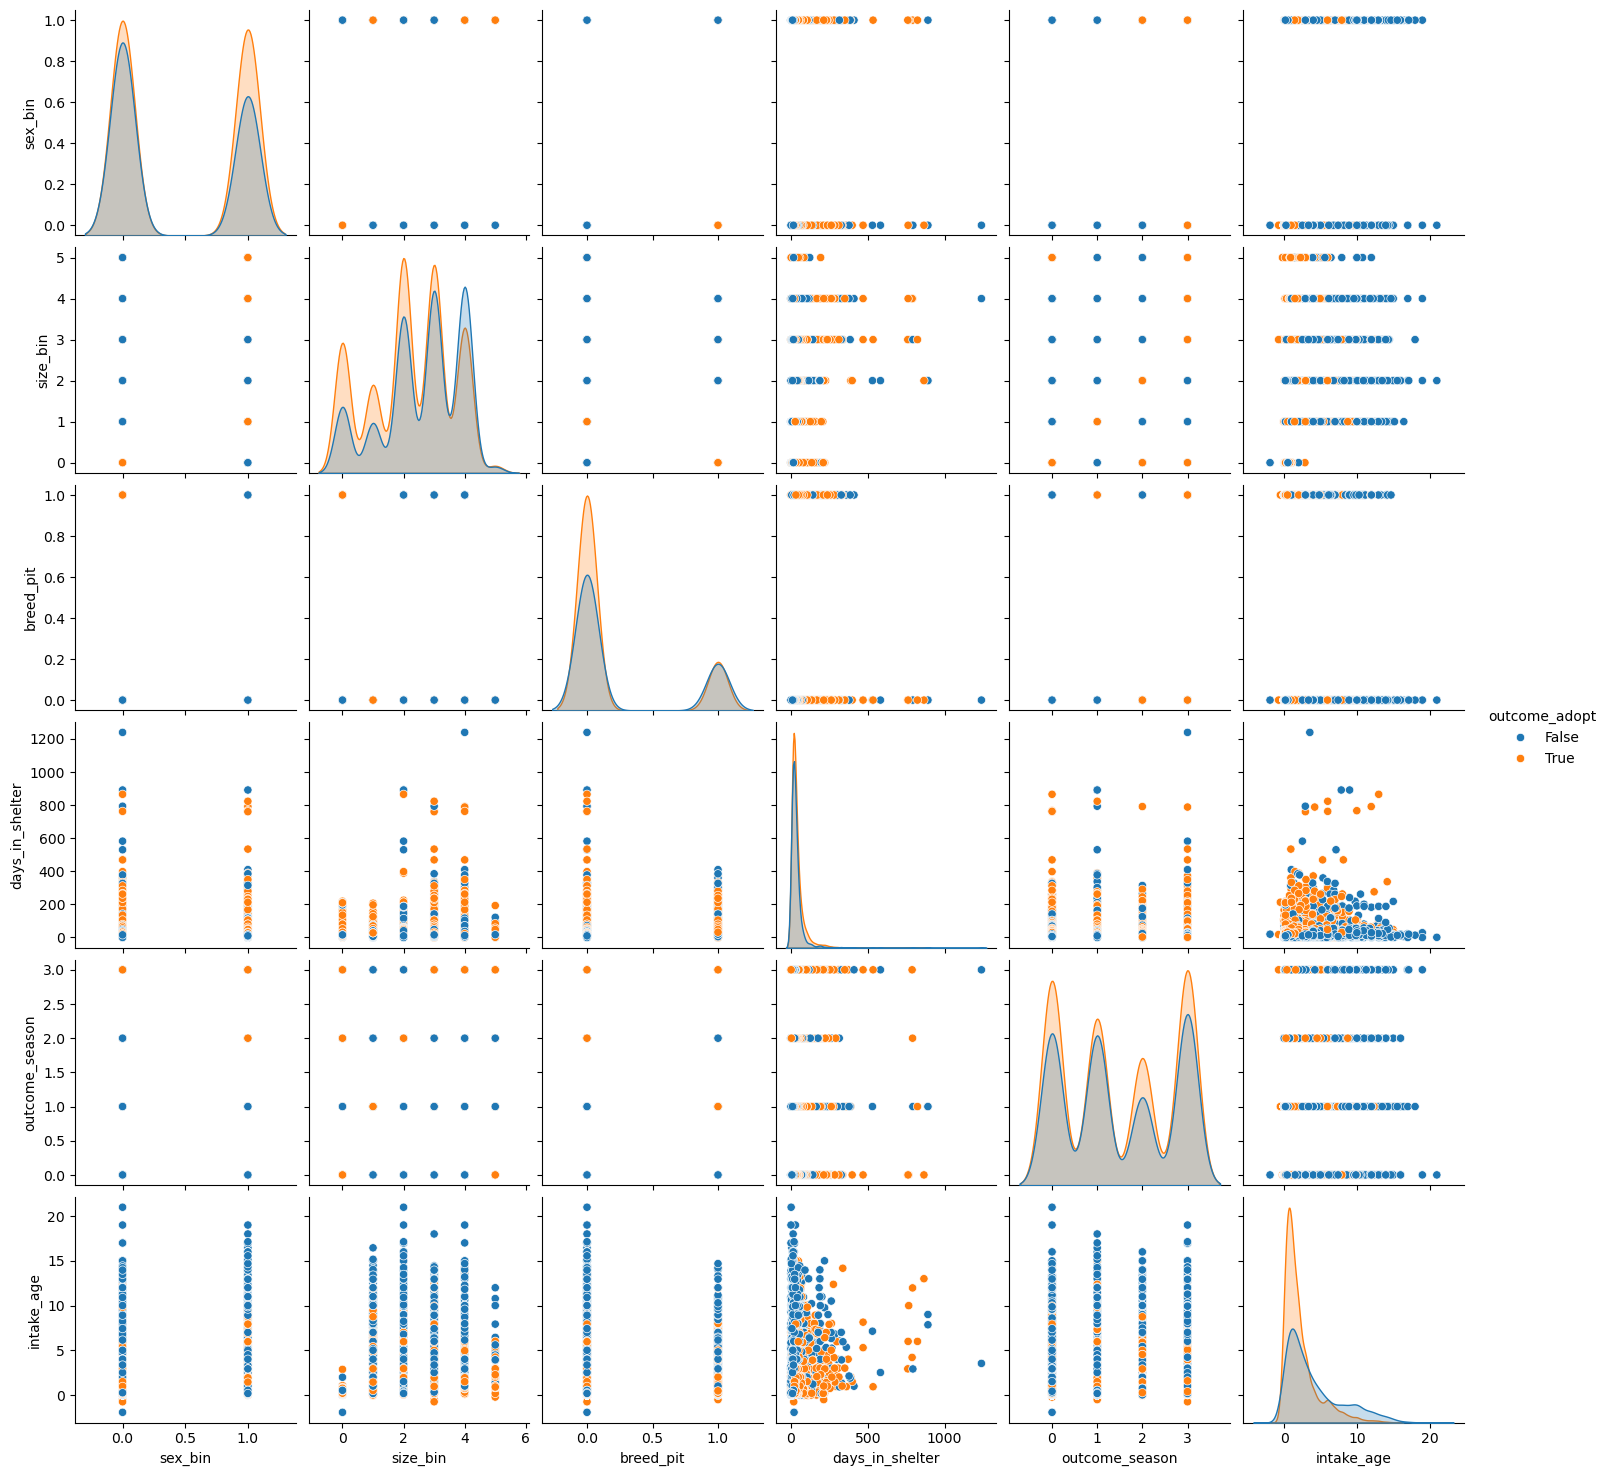

In [7]:
sns.pairplot(data=dog_df,
x_vars=feature_list,
y_vars=feature_list,
hue="outcome_adopt")

<Axes: xlabel='days_in_shelter', ylabel='Proportion'>

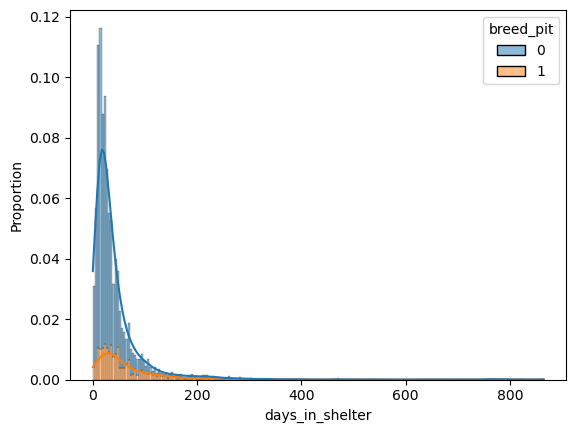

In [12]:
sns.histplot(data=dog_df[dog_df.outcome_adopt==True], x="days_in_shelter", hue="breed_pit", stat='proportion', multiple='stack', kde=True)

In [13]:
X_t, X_h, y_t, y_h = train_test_split(dog_df[feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2)
                                      

In [19]:
adoption_prob_cutoff = 1/2

for DEP in range(3, 12):
    rf_forst = RandomForestClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)
    et_forst = ExtraTreesClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)

    score_df = pd.DataFrame({'feature':X_t.columns, 'rf_importance':rf_forst.feature_importances_, 'et_importance':et_forst.feature_importances_}, index=X_t.columns)
    print( score_df.loc["breed_pit"] )
    del score_df

    rf_adopt_pred = 1 * (rf_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "RandomForest: ", DEP, round(accuracy_score(y_pred = rf_adopt_pred, y_true = y_t), 2))

    et_adopt_pred = 1 * (et_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "ExtraForest: ", DEP, round(accuracy_score(y_pred = et_adopt_pred, y_true = y_t), 2))

    del rf_forst, rf_adopt_pred, et_forst, et_adopt_pred
    print()

feature          breed_pit
rf_importance     0.038947
et_importance     0.128769
Name: breed_pit, dtype: object
RandomForest:  3 0.68
ExtraForest:  3 0.65

feature          breed_pit
rf_importance     0.041245
et_importance     0.109519
Name: breed_pit, dtype: object
RandomForest:  4 0.69
ExtraForest:  4 0.65

feature          breed_pit
rf_importance     0.041709
et_importance     0.093561
Name: breed_pit, dtype: object
RandomForest:  5 0.71
ExtraForest:  5 0.66

feature          breed_pit
rf_importance     0.043191
et_importance     0.081108
Name: breed_pit, dtype: object
RandomForest:  6 0.71
ExtraForest:  6 0.67

feature          breed_pit
rf_importance     0.039903
et_importance     0.072959
Name: breed_pit, dtype: object
RandomForest:  7 0.73
ExtraForest:  7 0.68

feature          breed_pit
rf_importance     0.038344
et_importance     0.063306
Name: breed_pit, dtype: object
RandomForest:  8 0.75
ExtraForest:  8 0.7

feature          breed_pit
rf_importance     0.034572
et_importan

In [20]:
adoption_prob_cutoff = 2/3

for DEP in range(3, 12):
    rf_forst = RandomForestClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)
    et_forst = ExtraTreesClassifier(n_estimators=500, max_depth=DEP).fit(X_t, y_t)

    score_df = pd.DataFrame({'feature':X_t.columns, 'rf_importance':rf_forst.feature_importances_, 'et_importance':et_forst.feature_importances_}, index=X_t.columns)
    print( score_df.loc["breed_pit"] )
    del score_df

    rf_adopt_pred = 1 * (rf_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "RandomForest: ", DEP, round(accuracy_score(y_pred = rf_adopt_pred, y_true = y_t), 2))

    et_adopt_pred = 1 * (et_forst.predict_proba(X_t)[:, 1] > adoption_prob_cutoff )
    print( "ExtraForest: ", DEP, round(accuracy_score(y_pred = et_adopt_pred, y_true = y_t), 2))

    del rf_forst, rf_adopt_pred, et_forst, et_adopt_pred
    print()

feature          breed_pit
rf_importance     0.043059
et_importance     0.146234
Name: breed_pit, dtype: object
RandomForest:  3 0.5
ExtraForest:  3 0.45

feature          breed_pit
rf_importance     0.038624
et_importance     0.114879
Name: breed_pit, dtype: object
RandomForest:  4 0.57
ExtraForest:  4 0.47

feature          breed_pit
rf_importance      0.04391
et_importance     0.097096
Name: breed_pit, dtype: object
RandomForest:  5 0.62
ExtraForest:  5 0.49

feature          breed_pit
rf_importance     0.042393
et_importance     0.083144
Name: breed_pit, dtype: object
RandomForest:  6 0.65
ExtraForest:  6 0.52

feature          breed_pit
rf_importance     0.039509
et_importance     0.071528
Name: breed_pit, dtype: object
RandomForest:  7 0.68
ExtraForest:  7 0.55

feature          breed_pit
rf_importance     0.037967
et_importance     0.064796
Name: breed_pit, dtype: object
RandomForest:  8 0.71
ExtraForest:  8 0.58

feature          breed_pit
rf_importance     0.034444
et_importan